<a href="https://colab.research.google.com/github/openknowledge/mlops/blob/main/notebooks/exploration-tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase I: Exploration


In [1]:
import numpy as np
np.__version__

'1.21.6'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 16

# Step 1: Loading and exploring our data set

In [3]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/openknowledge/mlops/main/data/reference.csv', delimiter=';')
# df = pd.read_csv(f'../data/reference.csv', delimiter=';')

In [4]:
df.head(10)

,training,age,emergency_braking,braking_distance,power,miles,risk,group_name,group
0,0,41.951100,0,40.933328,122.238329,98.509765,3.700073,high,0
1,0,24.368286,1,44.797317,113.765298,46.324178,2.447873,medium,1
2,0,18.314649,1,41.587241,143.427269,76.862968,4.079834,high,0
3,0,51.265254,1,47.266716,111.578133,102.697069,5.087831,high,0
4,0,23.578861,0,42.835319,145.994235,63.690055,3.739299,high,0
5,0,29.506037,1,46.547745,139.820214,66.610999,3.130142,high,0
6,0,21.289385,1,40.666499,134.749599,63.146964,1.774027,medium,1
7,1,47.459483,0,35.168550,142.215391,123.385272,0.084924,low,2
8,1,20.573680,1,41.798826,114.677871,103.853842,-0.033755,low,2
9,0,24.639606,1,40.801391,162.457198,44.292386,2.456763,medium,1


In [5]:
df.describe()

,training,age,emergency_braking,braking_distance,power,miles,risk,group
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.210000,35.146663,0.394000,39.903294,134.888089,80.965668,2.183617,0.901333
std,0.407444,12.765348,0.488798,4.781834,35.048570,25.496752,2.481164,0.815705
min,0.000000,15.949545,0.000000,24.368993,38.246253,18.796953,-5.289352,0.000000
25%,0.000000,25.141921,0.000000,36.733165,110.008660,62.666195,0.708085,0.000000
50%,0.000000,32.714683,0.000000,39.867888,131.055019,77.094819,2.386835,1.000000
75%,0.000000,42.633629,1.000000,42.938777,157.319959,95.568682,3.874869,2.000000
max,1.000000,86.213394,1.000000,56.463472,285.750164,211.807417,10.343054,2.000000


In [6]:
import seaborn as sns

In [7]:
labels = ["High Risk", "Medium Risk", "Low Risk"]
markers = ['v', 'd', '^']
# colors = ['#FF8080', '#FFFF80', '#8080FF']
colors = ['#FF0000', '#FFFF00', '#0000FF']

In [8]:
features = ['training', 'age', 'emergency_braking', 'braking_distance', 'power', 'miles', 'risk']

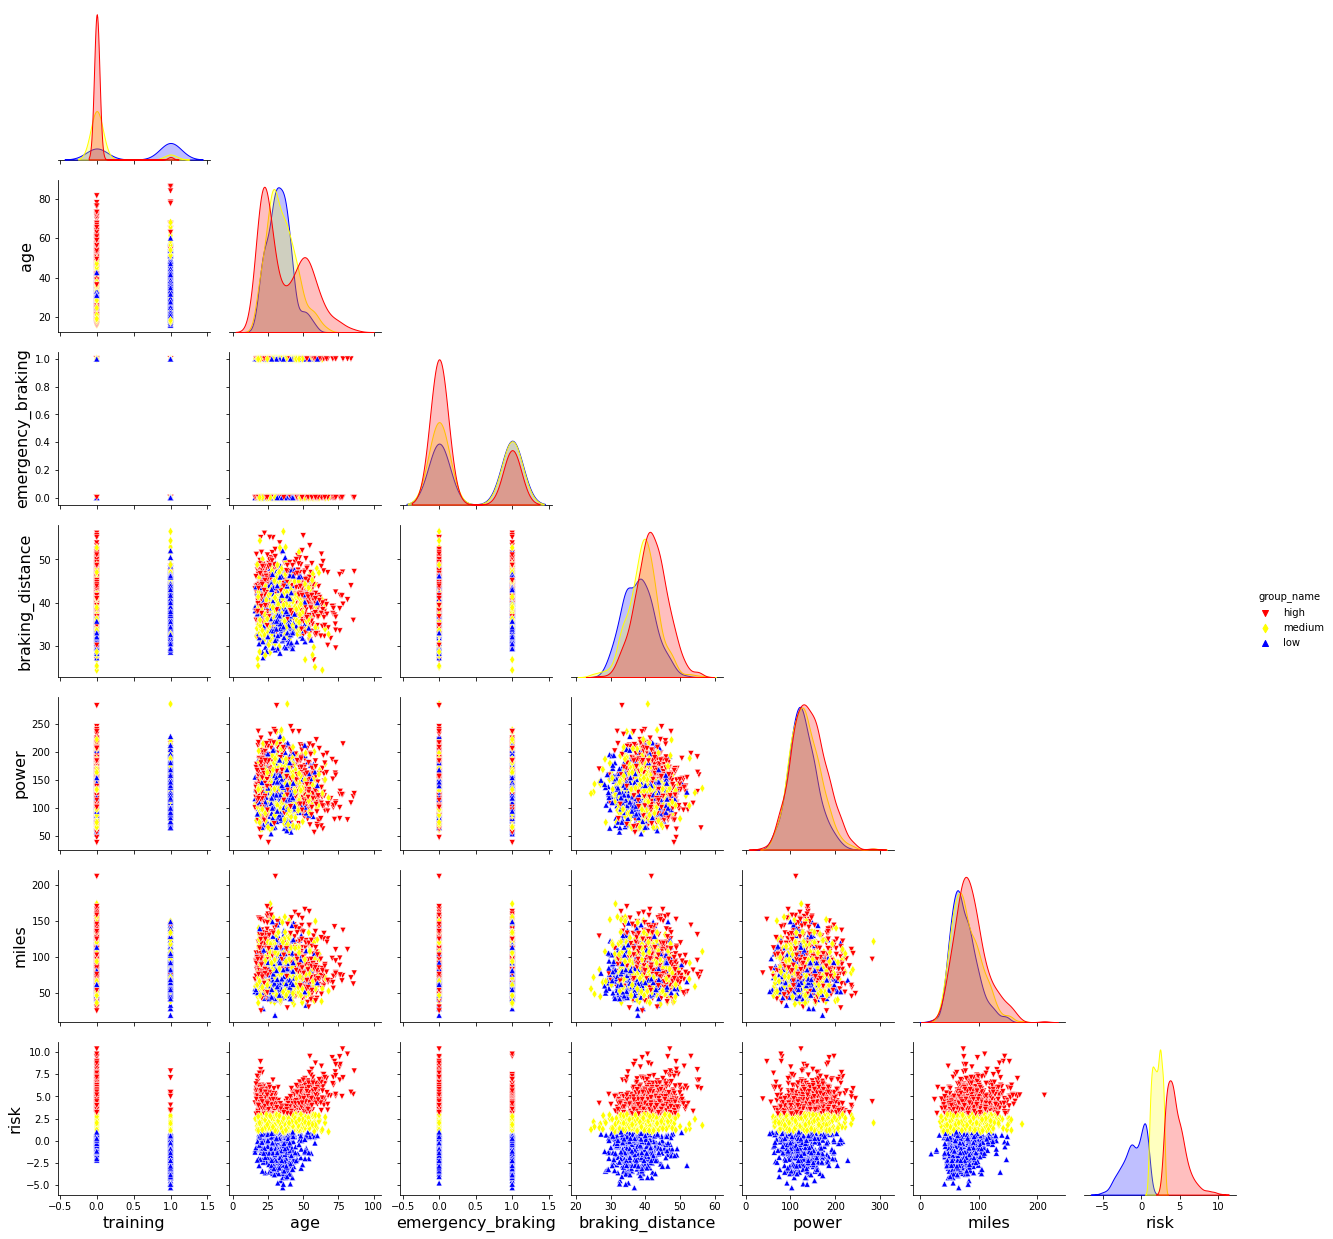

In [9]:
sns.pairplot(df, 
             kind="scatter", 
             diag_kind="kde",
             corner=True, 
             hue='group_name',
             hue_order = ['high', 'medium', 'low'],
             palette=colors, 
             markers=markers,
             vars=features);

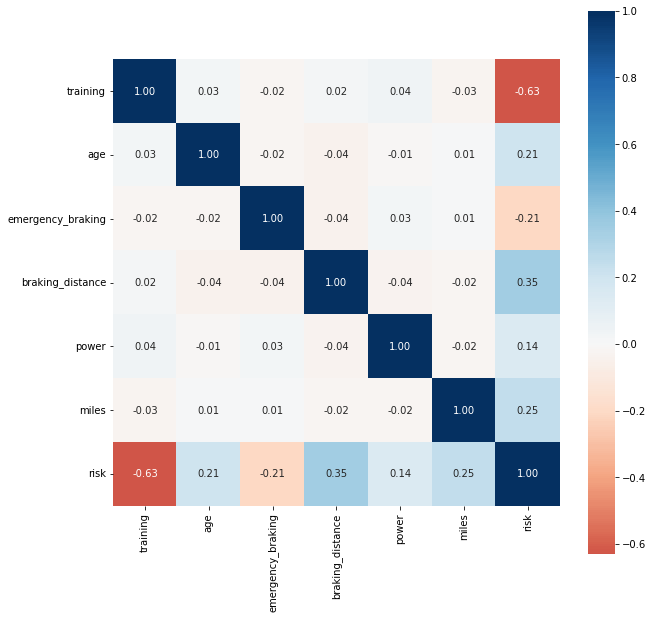

In [10]:
plt.figure(figsize=(10, 10))

cm = df.corr()
cm3 = cm.iloc[:len(features), :len(features)]

hm = sns.heatmap(cm3,
                cbar=True,
                annot=True,
                square=True,
                cmap='RdBu', 
                center=0,
                fmt='.2f',
                yticklabels=features,
                xticklabels=features)

# Step 2: Training

## Train / Test Split

In [11]:
y = df['group'].values
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([580, 488, 432]))

In [12]:
X = df.drop(['risk', 'group', 'group_name'], axis='columns').values
X.shape, y.shape

((1500, 6), (1500,))

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1200, 6), (300, 6), (1200,), (300,))

## ML Approach: Neural Network

In [14]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve

In [15]:
from lrcurve import KerasLearningCurve

In [16]:
# If this gives red output everything is fine
import tensorflow as tf
tf.__version__

'2.9.2'

In [17]:
# disable gpus, can also give red output and everything is just fine
tf.config.set_visible_devices([], 'GPU')

In [18]:
tf.random.set_seed(42)

## Normalization

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization

In [19]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [20]:
normalizer.adapt(X_train)

In [21]:
X_train.mean(axis=0), X_train.std(axis=0)

(array([  0.21      ,  35.04868507,   0.38416667,  39.85941241,
        135.44608245,  80.75870963]),
 array([ 0.40730824, 12.83783712,  0.48639761,  4.7835018 , 35.33754623,
        25.39554043]))

In [22]:
normalizer.weights

[<tf.Variable 'mean:0' shape=(6,) dtype=float32, numpy=
 array([  0.20999996,  35.048683  ,   0.38416666,  39.85941   ,
        135.44609   ,  80.75871   ], dtype=float32)>,
 <tf.Variable 'variance:0' shape=(6,) dtype=float32, numpy=
 array([1.6590004e-01, 1.6481006e+02, 2.3658259e-01, 2.2881884e+01,
        1.2487423e+03, 6.4493372e+02], dtype=float32)>,
 <tf.Variable 'count:0' shape=() dtype=int64, numpy=1200>]

In [23]:
df.columns

Index(['training', 'age', 'emergency_braking', 'braking_distance', 'power',
       'miles', 'risk', 'group_name', 'group'],
      dtype='object')

In [24]:
normalizer.mean, np.sqrt(normalizer.variance)

(<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[  0.20999996,  35.048683  ,   0.38416666,  39.85941   ,
         135.44609   ,  80.75871   ]], dtype=float32)>,
 array([[ 0.40730828, 12.837837  ,  0.48639756,  4.783501  , 35.337547  ,
         25.395546  ]], dtype=float32))

In [25]:
from tensorflow.keras.layers import InputLayer, Dense, Dropout, \
                                    BatchNormalization, Activation

num_features = X.shape[1]
dropout = 0.7
model = tf.keras.Sequential()

model.add(InputLayer(name='input', input_shape=(num_features,)))
model.add(normalizer)

model.add(Dense(100, name='hidden1'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(100, name='hidden2'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(100, name='hidden3'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(name='output', units=3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 hidden1 (Dense)             (None, 100)               700       
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 hidden2 (Dense)             (None, 100)               1

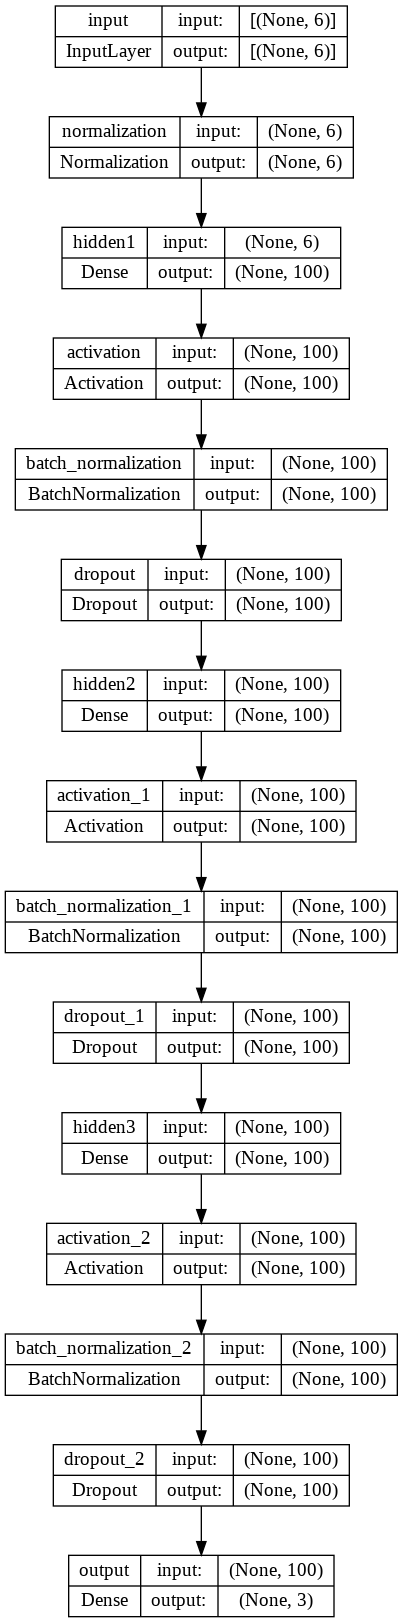

In [26]:
tf.keras.utils.plot_model(model, 
                          show_shapes=True, 
                          show_layer_names=True, 
                          # rankdir='LR'
                          )

In [27]:
%%time 

BATCH_SIZE = 32
# BATCH_SIZE = 64
EPOCHS = 50

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 16.3 s, sys: 862 ms, total: 17.2 s
Wall time: 21.9 s


In [28]:
train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_metric

38/38 [==============================] - 0s 6ms/step - loss: 0.3898 - accuracy: 0.8542


(0.38977479934692383, 0.8541666865348816)

In [29]:
test_loss, test_metric = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
test_loss, test_metric

10/10 [==============================] - 0s 5ms/step - loss: 0.3811 - accuracy: 0.8700


(0.3811129927635193, 0.8700000047683716)

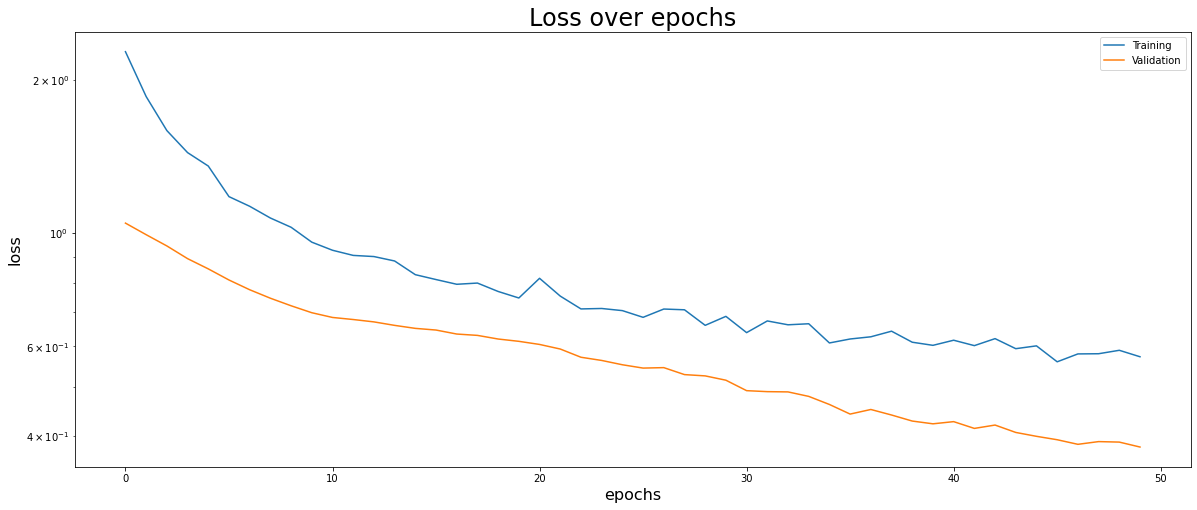

In [30]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over epochs')

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['Training', 'Validation']);

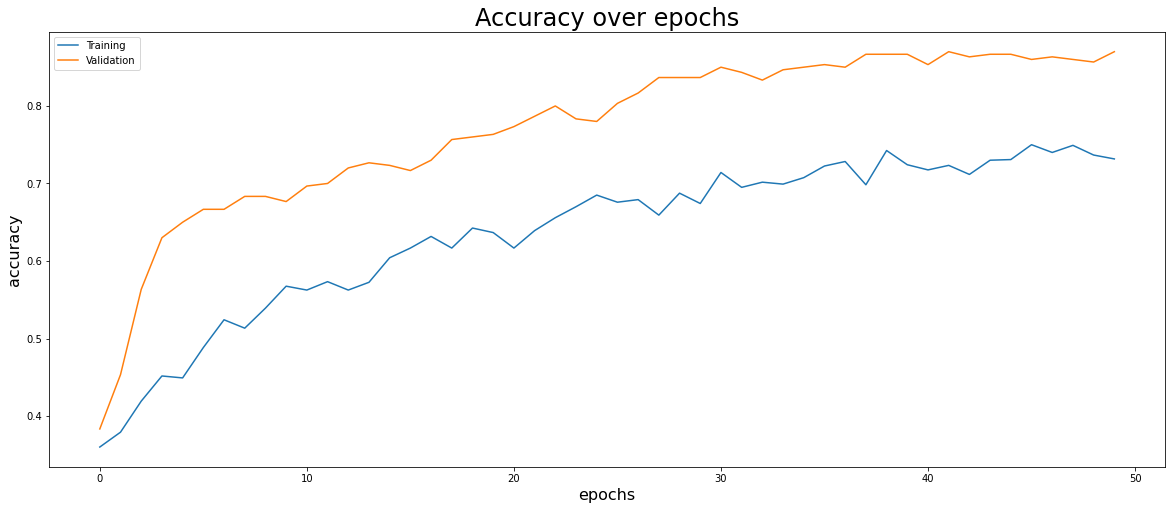

In [31]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over epochs')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation']);

# Saving Model

In [32]:
# model.save?

In [33]:
model.save('classifier.h5', save_format='h5')

In [34]:
model.save('classifier', save_format='tf')

In [35]:
!ls -l

total 452
drwxr-xr-x 4 root root   4096 Oct 14 10:16 classifier
-rw-r--r-- 1 root root 338288 Oct 14 10:16 classifier.h5
-rw-r--r-- 1 root root 111203 Oct 14 10:16 model.png
drwxr-xr-x 1 root root   4096 Oct  7 13:35 sample_data


In [36]:
!ls -l classifier/

total 352
drwxr-xr-x 2 root root   4096 Oct 14 10:16 assets
-rw-r--r-- 1 root root  22654 Oct 14 10:16 keras_metadata.pb
-rw-r--r-- 1 root root 324882 Oct 14 10:16 saved_model.pb
drwxr-xr-x 2 root root   4096 Oct 14 10:16 variables


In [37]:
!tar czvf classifier.tgz ./classifier

./classifier/
./classifier/keras_metadata.pb
./classifier/variables/
./classifier/variables/variables.data-00000-of-00001
./classifier/variables/variables.index
./classifier/assets/
./classifier/saved_model.pb


In [38]:
!ls -l

total 732
drwxr-xr-x 4 root root   4096 Oct 14 10:16 classifier
-rw-r--r-- 1 root root 338288 Oct 14 10:16 classifier.h5
-rw-r--r-- 1 root root 284931 Oct 14 10:16 classifier.tgz
-rw-r--r-- 1 root root 111203 Oct 14 10:16 model.png
drwxr-xr-x 1 root root   4096 Oct  7 13:35 sample_data
